In [1]:
# Import required libraries and utilities for EDA, splitting, preprocessing, and saving artifacts.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from IPython.display import display
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder

In [2]:
# Load training and test CSV files, then preview the training dataframe.
train_path = "train.csv"
test_path  = "test.csv"
train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)
print("train_df:", train_df.shape)
display(train_df.head())

train_df: (41348, 7)


,neighbourhood_group,room_type,minimum_nights,amenity_score,number_of_reviews,availability_365,price_class
0,Manhattan,NaN,2.0,82.5,15.0,254.0,3
1,Manhattan,Private room,2.0,53.7,1.0,0.0,1
2,Brooklyn,Private room,2.0,47.8,70.0,90.0,1
3,Manhattan,Entire home/apt,2.0,58.8,1.0,NaN,1
4,Bronx,Private room,2.0,32.2,0.0,89.0,1


In [3]:
# Print core training dataset structure, including sample count, feature count, and target presence.
name = "TRAIN"
target_col = "price_class"
print(f"{name} DATASET STRUCTURE")
n_samples, n_cols = train_df.shape
print(f"Samples (rows): {n_samples}")
print(f"Total columns : {n_cols}")

if target_col in train_df.columns:
    feature_cols = [c for c in train_df.columns if c != target_col]
    print(f"Features (excluding target '{target_col}'): {len(feature_cols)}")
    print(f"Target column: '{target_col}'")
else:
    feature_cols = list(train_df.columns)
    print(f"Features: {len(feature_cols)}")
    print("Target column not found in this dataset.")

TRAIN DATASET STRUCTURE
Samples (rows): 41348
Total columns : 7
Features (excluding target 'price_class'): 6
Target column: 'price_class'


In [4]:
# Summarize data types across columns in the training dataframe.
dtype_counts = train_df.dtypes.value_counts()
print("\nData type counts:")
display(dtype_counts.to_frame(name="count"))


Data type counts:


,count
float64,4
object,2
int64,1


In [5]:
# Report the top training columns by missing value count.
missing_count = train_df.isna().sum().sort_values(ascending=False)
print("\nMissing values count (top 20):")
display(missing_count.head(20).to_frame(name="missing_count"))


Missing values count (top 20):


,missing_count
minimum_nights,1322
number_of_reviews,1123
amenity_score,916
neighbourhood_group,839
room_type,611
availability_365,595
price_class,0


In [6]:
# Report the top training columns by missing value percentage.
missing_pct = (train_df.isna().mean() * 100).round(3).sort_values(ascending=False)
print("\nMissing values percentage (top 20):")
display(missing_pct.head(20).to_frame(name="missing_pct"))


Missing values percentage (top 20):


,missing_pct
minimum_nights,3.197
number_of_reviews,2.716
amenity_score,2.215
neighbourhood_group,2.029
room_type,1.478
availability_365,1.439
price_class,0.000


In [7]:
# Build a per-column training summary and display columns with highest missingness.
summary = pd.DataFrame({
    "column": train_df.columns,
    "dtype": train_df.dtypes.astype(str).values,
    "non_null": train_df.notna().sum().values,
    "missing": train_df.isna().sum().values,
    "n_unique": train_df.nunique(dropna=True).values,
}).sort_values(["n_unique"], ascending=False)

print("\nTop columns by missing no:")
display(summary.head(15))


Top columns by missing no:


,column,dtype,non_null,missing,n_unique
3,amenity_score,float64,40432,916,891
4,number_of_reviews,float64,40225,1123,379
5,availability_365,float64,40753,595,366
2,minimum_nights,float64,40026,1322,98
0,neighbourhood_group,object,40509,839,5
6,price_class,int64,41348,0,4
1,room_type,object,40737,611,3


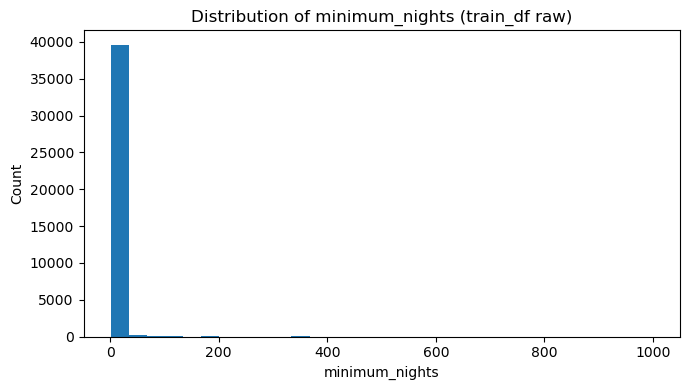

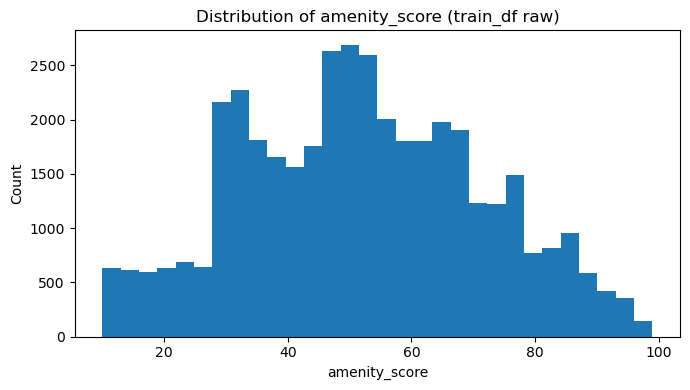

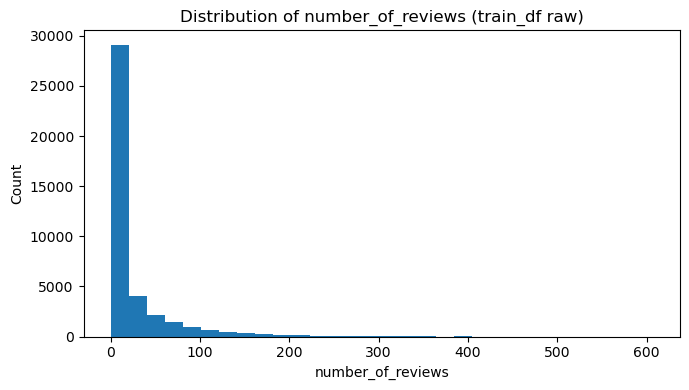

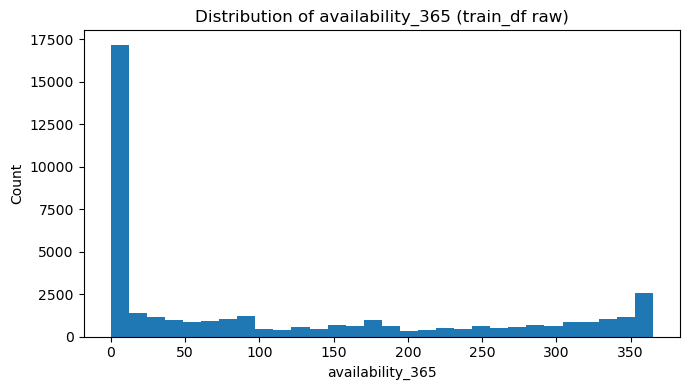

In [8]:
# Plot histograms for numeric columns in the raw training dataframe.
if "train_df" not in globals():
    raise NameError("train_df is not defined. Load the raw training data first.")

df_num = train_df
target = target_col if "target_col" in globals() else "price_class"

num_cols = df_num.select_dtypes(exclude=["object"]).columns.tolist()
if target in num_cols:
    num_cols.remove(target)

if len(num_cols) == 0:
    print("No numeric columns found.")
else:
    for col in num_cols:
        plt.figure(figsize=(7, 4))
        plt.hist(df_num[col], bins=30)
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.title(f"Distribution of {col} (train_df raw)")
        plt.tight_layout()
        plt.show()

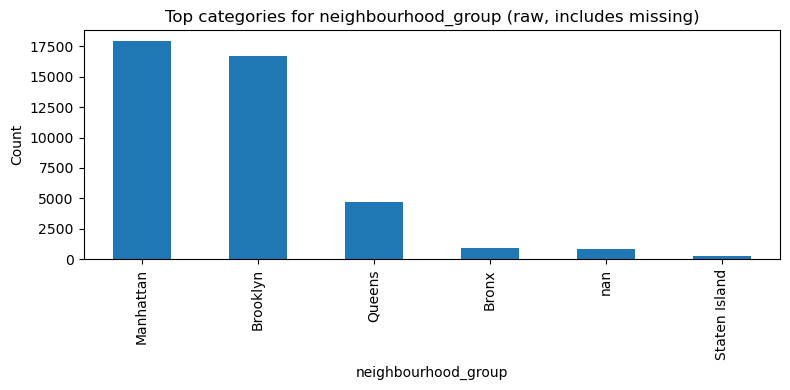

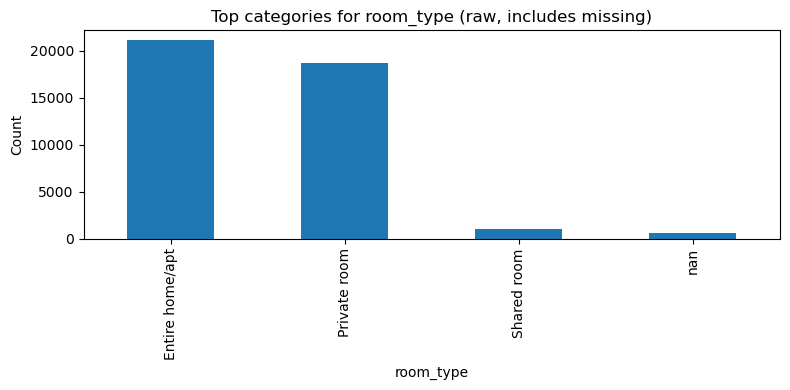

In [9]:
# Plot top categorical value distributions in the raw training dataframe.
cat_cols = train_df.select_dtypes(include=["object", "category"]).columns.tolist()

for col in cat_cols:
    plt.figure(figsize=(8, 4))
    train_df[col].value_counts(dropna=False).head(20).plot(kind="bar")
    plt.title(f"Top categories for {col} (raw, includes missing)")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

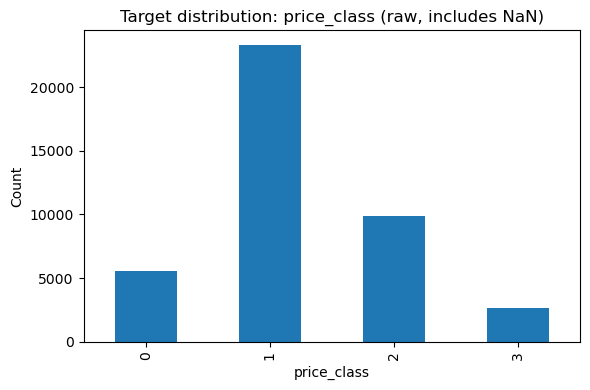

In [10]:
# Visualize the raw target class distribution in the training dataframe.
if target_col in train_df.columns:
    plt.figure(figsize=(6, 4))
    train_df[target_col].value_counts(dropna=False).sort_index().plot(kind="bar")
    plt.title(f"Target distribution: {target_col} (raw, includes NaN)")
    plt.xlabel(target_col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
else:
    print(f"Target column '{target_col}' not found in train_df.")

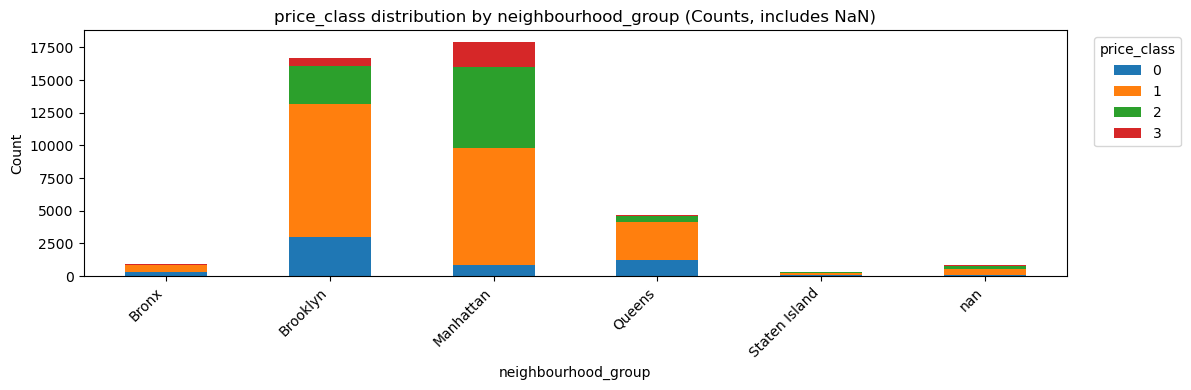

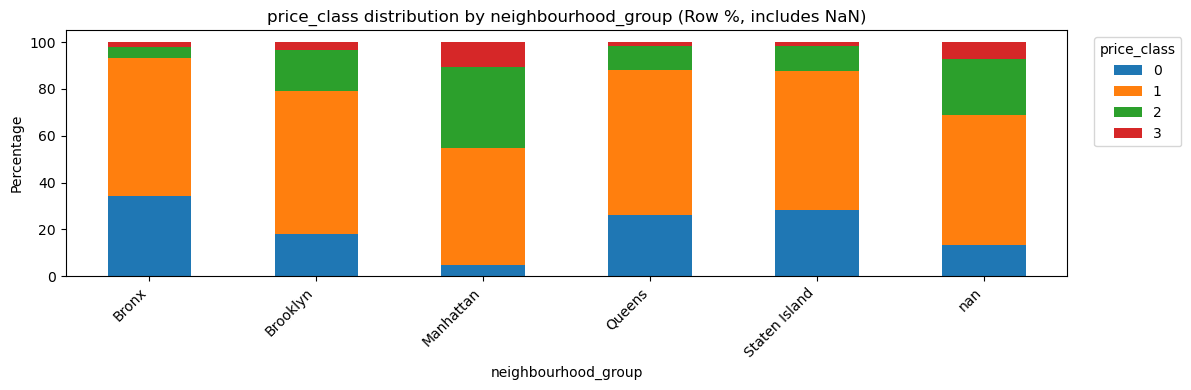

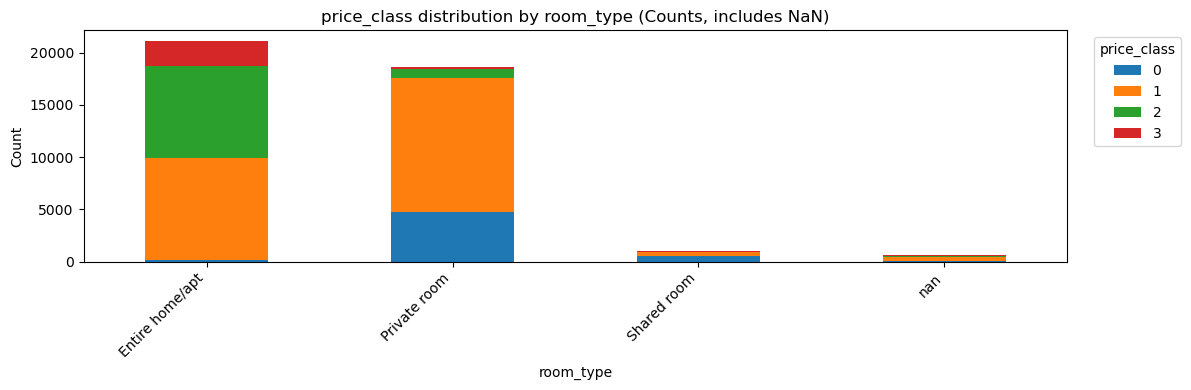

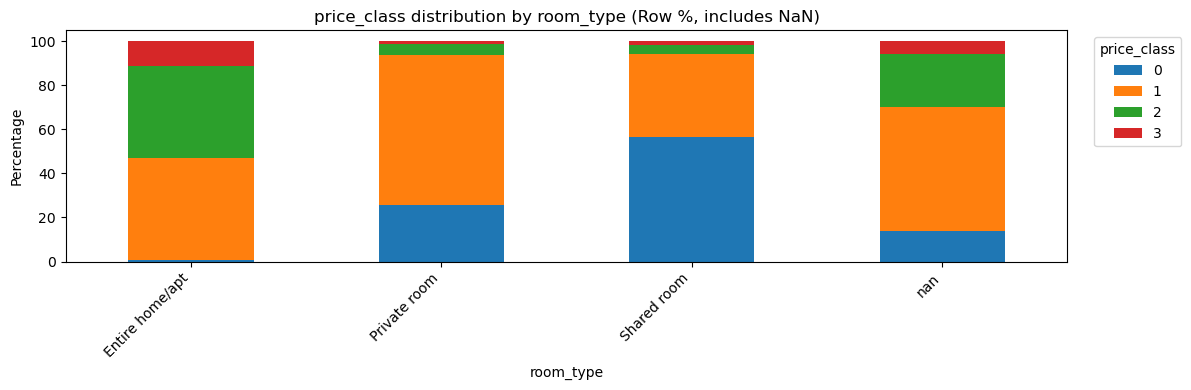

In [11]:
# Compare target distribution across categorical features using count and row-percentage stacked bars.
target_col = "price_class"


cat_cols = train_df.select_dtypes(include=["object", "category"]).columns.drop(target_col, errors="ignore")

top_n = 15

if target_col not in train_df.columns:
    print(f"Target column '{target_col}' not found in train_df.")
elif len(cat_cols) == 0:
    print("No categorical columns found (object/category).")
else:
    for col in cat_cols:
        ct = pd.crosstab(train_df[col], train_df[target_col], dropna=False)

        if ct.shape[0] > top_n:
            totals = ct.sum(axis=1).sort_values(ascending=False)
            keep = totals.head(top_n - 1).index
            other = ct.loc[~ct.index.isin(keep)].sum(axis=0).to_frame().T
            other.index = ["Other"]
            ct = pd.concat([ct.loc[keep], other])

        ax = ct.plot(kind="bar", stacked=True, figsize=(12, 4))
        ax.set_title(f"{target_col} distribution by {col} (Counts, includes NaN)")
        ax.set_xlabel(col)
        ax.set_ylabel("Count")
        plt.xticks(rotation=45, ha="right")
        plt.legend(title=target_col, bbox_to_anchor=(1.02, 1), loc="upper left")
        plt.tight_layout()
        plt.show()

        pct = (ct.div(ct.sum(axis=1), axis=0) * 100).round(2)
        ax = pct.plot(kind="bar", stacked=True, figsize=(12, 4))
        ax.set_title(f"{target_col} distribution by {col} (Row %, includes NaN)")
        ax.set_xlabel(col)
        ax.set_ylabel("Percentage")
        plt.xticks(rotation=45, ha="right")
        plt.legend(title=target_col, bbox_to_anchor=(1.02, 1), loc="upper left")
        plt.tight_layout()
        plt.show()

In [12]:
# Compute and rank numeric feature correlation strength with the target on raw training data.
if target_col not in train_df.columns:
    raise ValueError(f"Target column '{target_col}' not found in train_df.")

num_cols_rel = train_df.select_dtypes(exclude=["object"]).columns.tolist()
if target_col in num_cols_rel:
    num_cols_rel.remove(target_col)

target_is_numeric = pd.api.types.is_numeric_dtype(train_df[target_col])
y_rel = train_df[target_col] if target_is_numeric else train_df[target_col].astype("category").cat.codes

if len(num_cols_rel) == 0:
    num_strength = pd.Series(dtype=float)
    print("No numeric features found.")
else:
    num_strength = train_df[num_cols_rel].corrwith(y_rel)
    num_strength = num_strength.sort_values(key=lambda s: s.abs(), ascending=False, na_position="last")
    display(num_strength.to_frame("corr_with_target").head(15))

,corr_with_target
amenity_score,0.875322
availability_365,0.096385
number_of_reviews,-0.034141
minimum_nights,0.015818


amenity_score: NaN in feature = 916, NaN in target = 0


<Figure size 700x400 with 0 Axes>

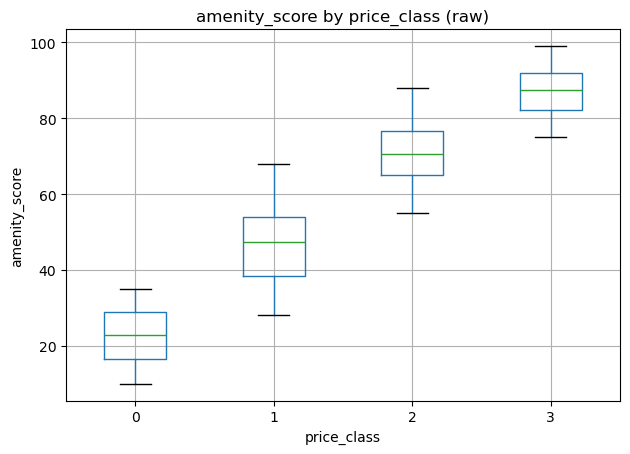

availability_365: NaN in feature = 595, NaN in target = 0


<Figure size 700x400 with 0 Axes>

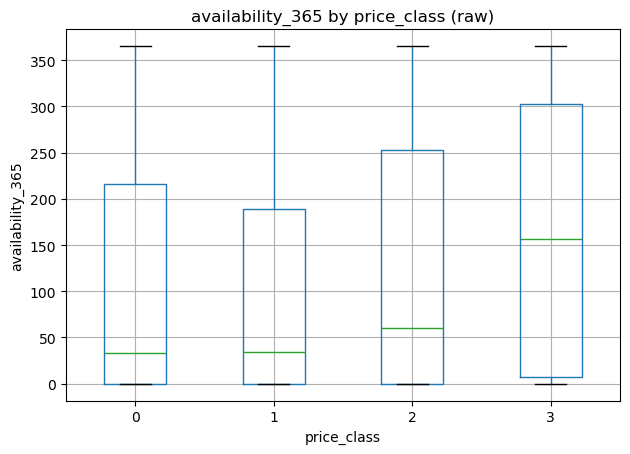

number_of_reviews: NaN in feature = 1123, NaN in target = 0


<Figure size 700x400 with 0 Axes>

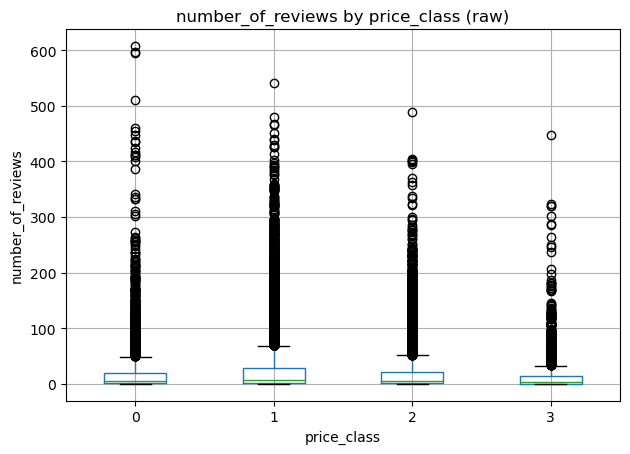

minimum_nights: NaN in feature = 1322, NaN in target = 0


<Figure size 700x400 with 0 Axes>

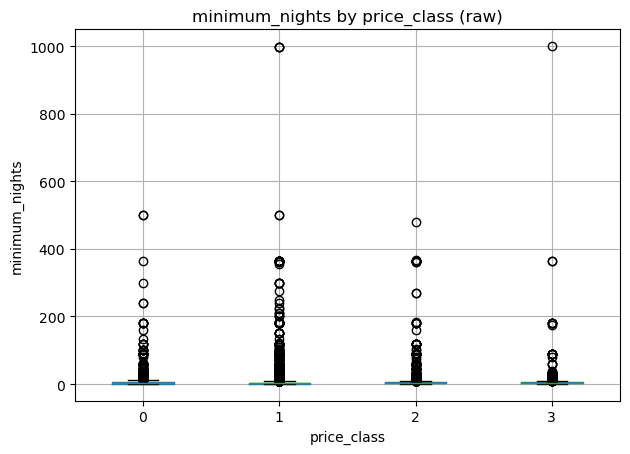

In [13]:
# Plot boxplots of the top numeric features against the target classes.
top_num = num_strength.head(6).index.tolist()
for col in top_num:
    plot_df = train_df[[target_col, col]]

    print(
        f"{col}: NaN in feature = {plot_df[col].isna().sum()}, "
        f"NaN in target = {plot_df[target_col].isna().sum()}"
    )

    plt.figure(figsize=(7, 4))
    plot_df.boxplot(column=col, by=target_col)
    plt.title(f"{col} by {target_col} (raw)")
    plt.suptitle("")
    plt.xlabel(target_col)
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

NaN count per column:


,nan_count
amenity_score,916
availability_365,595
number_of_reviews,1123
minimum_nights,1322
price_class,0


Total NaNs in corr_df: 3956
Rows with at least one NaN: 3800


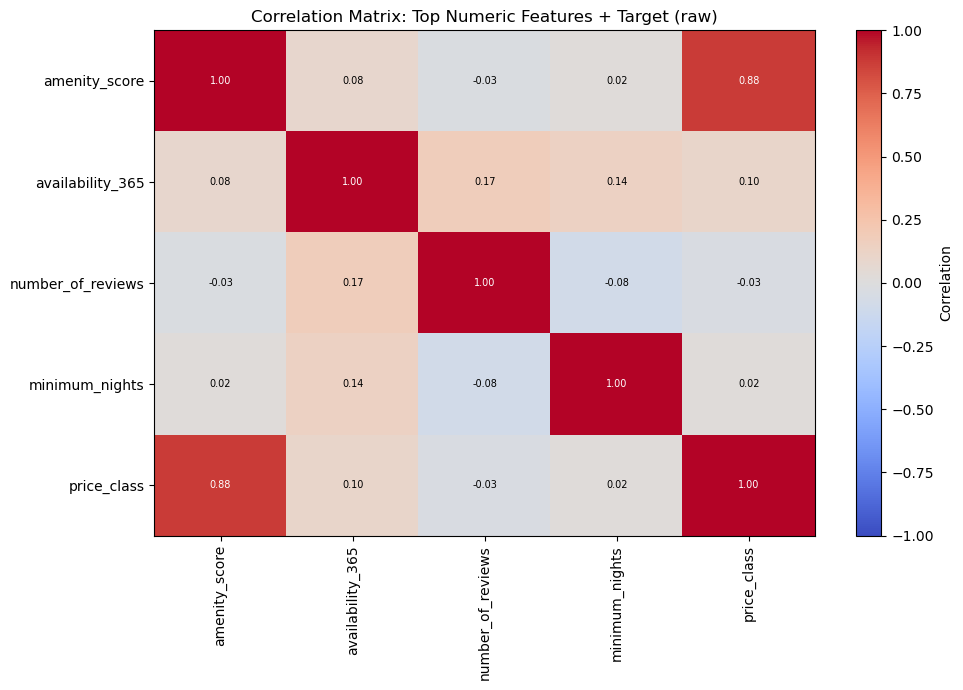

In [14]:
# Create a correlation heatmap for top numeric features and the target on raw data.
top_corr_cols = num_strength.head(10).index.tolist()
if len(top_corr_cols) >= 2:
    corr_df = train_df[top_corr_cols].copy()

    if target_is_numeric:
        corr_df[target_col] = train_df[target_col]
    else:
        corr_df[f"{target_col}_code"] = train_df[target_col].astype("category").cat.codes

    nan_counts = corr_df.isna().sum()
    print("NaN count per column:")
    display(nan_counts.to_frame("nan_count"))

    print("Total NaNs in corr_df:", int(corr_df.isna().sum().sum()))
    print("Rows with at least one NaN:", int(corr_df.isna().any(axis=1).sum()))

    corr_mat = corr_df.corr()

    fig, ax = plt.subplots(figsize=(10, 7))
    img = ax.imshow(
        corr_mat.values,
        cmap="coolwarm",
        vmin=-1,
        vmax=1,
        aspect="auto",
        interpolation="nearest"
    )

    ax.grid(False)
    ax.set_xticks(range(len(corr_mat.columns)))
    ax.set_yticks(range(len(corr_mat.index)))
    ax.set_xticklabels(corr_mat.columns, rotation=90)
    ax.set_yticklabels(corr_mat.index)

    for i in range(corr_mat.shape[0]):
        for j in range(corr_mat.shape[1]):
            v = corr_mat.iloc[i, j]
            c = "white" if abs(v) >= 0.5 else "black"
            ax.text(j, i, f"{v:.2f}", ha="center", va="center", color=c, fontsize=7)

    fig.colorbar(img, ax=ax, label="Correlation")
    ax.set_title("Correlation Matrix: Top Numeric Features + Target (raw)")
    fig.tight_layout()
    plt.show()
else:
    print("Not enough numeric features for this heatmap.")

In [15]:
# Split training data into train and validation subsets with target-aware stratification.
target_col = "price_class"

if target_col not in train_df.columns:
    raise ValueError(f"Target column '{target_col}' not found in train_df.")

X = train_df.drop(columns=[target_col])
y = train_df[target_col]


stratify_y = y if y.nunique(dropna=True) > 1 else None

X_train_df, X_val_df, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=stratify_y
)

train_split_df = X_train_df.copy()
train_split_df[target_col] = y_train

val_split_df = X_val_df.copy()
val_split_df[target_col] = y_val

print("train_split_df shape:", train_split_df.shape)
print("val_split_df shape  :", val_split_df.shape)
display(train_split_df.head())
display(val_split_df.head())

train_split_df shape: (33078, 7)
val_split_df shape  : (8270, 7)


,neighbourhood_group,room_type,minimum_nights,amenity_score,number_of_reviews,availability_365,price_class
35004,Manhattan,Entire home/apt,5.0,89.2,3.0,12.0,3
35818,Brooklyn,Private room,20.0,NaN,0.0,40.0,1
6658,Brooklyn,Private room,1.0,48.1,1.0,83.0,1
31372,Queens,NaN,1.0,59.3,1.0,0.0,2
25775,Manhattan,Private room,1.0,10.9,8.0,53.0,0


,neighbourhood_group,room_type,minimum_nights,amenity_score,number_of_reviews,availability_365,price_class
38358,Brooklyn,Entire home/apt,2.0,56.7,97.0,28.0,2
31497,Brooklyn,Entire home/apt,28.0,48.4,101.0,167.0,1
20761,Manhattan,Private room,16.0,12.2,0.0,NaN,0
25947,Manhattan,Shared room,22.0,32.6,1.0,12.0,0
38943,Manhattan,Entire home/apt,1.0,86.5,8.0,296.0,2


In [16]:
# Summarize train-split column completeness, missingness percentage, and uniqueness.
summary = pd.DataFrame({
    "column": train_split_df.columns,
    "dtype": train_split_df.dtypes.astype(str).values,
    "non_null": train_split_df.notna().sum().values,
    "missing": train_split_df.isna().sum().values,
    "missing_pct": (train_split_df.isna().mean().values * 100).round(3),
    "n_unique": train_split_df.nunique(dropna=True).values,
}).sort_values(["missing_pct", "n_unique"], ascending=False)

print("\n columns by missing (train split) after cleaning:")
display(summary.head(15))


 columns by missing (train split) after cleaning:


,column,dtype,non_null,missing,missing_pct,n_unique
2,minimum_nights,float64,32000,1078,3.259,94
4,number_of_reviews,float64,32150,928,2.805,359
3,amenity_score,float64,32364,714,2.159,891
0,neighbourhood_group,object,32405,673,2.035,5
1,room_type,object,32603,475,1.436,3
5,availability_365,float64,32604,474,1.433,366
6,price_class,int64,33078,0,0.000,4


In [17]:
# Analyze number_of_reviews missingness and distribution by neighbourhood_group and room_type.
group_cols = ["neighbourhood_group", "room_type"]
target_check = "number_of_reviews"


missing_cols = [c for c in (group_cols + [target_check]) if c not in train_split_df.columns]
if missing_cols:
    print("Skipping group missingness analysis on train split (missing columns):", missing_cols)
else:
    df_tmp = train_split_df.copy()

    summary = (
        df_tmp.groupby(group_cols, dropna=False)[target_check]
              .agg(
                  n="size",
                  missing=lambda s: s.isna().sum(),
                  missing_pct=lambda s: 100 * s.isna().mean(),
                  mean="mean",
                  median="median",
                  std="std",
              )
              .sort_values(["n"], ascending=False)
    )

    display(summary.head(25))

n  missing  missing_pct       mean  \
neighbourhood_group room_type                                                
Manhattan           Entire home/apt  8576      256     2.985075  17.945913   
Brooklyn            Private room     6613      198     2.994103  20.956820   
                    Entire home/apt  6273      186     2.965088  28.591917   
Manhattan           Private room     5214      129     2.474108  26.523697   
Queens              Private room     2222       47     2.115212  27.497931   
                    Entire home/apt  1372       32     2.332362  28.493284   
Bronx               Private room      445       12     2.696629  24.337182   
NaN                 Entire home/apt   342        9     2.631579  21.000000   
Manhattan           Shared room       304        7     2.302632  21.542088   
NaN                 Private room      295       13     4.406780  21.177305   
Brooklyn            Shared room       266       11     4.135338  15.909804   
Bronx               Entire home/apt   246        5     2.032520  32.136929   
Manhattan           NaN               209        5     2.392344  20.107843   
Brooklyn            NaN               193        6     3.108808  27.470588   
Staten Island       Private room      125        2     1.600000  30.016260   
                    Entire home/apt   116        1     0.862069  32.321739   
Queens              Shared room       115        4     3.478261  13.720721   
                    NaN                52        0     0.000000  20.403846   
Bronx               Shared room        41        1     2.439024   4.625000   
NaN                 Shared room        31        1     3.225806  14.800000   
Bronx               NaN                15        1     6.666667  35.071429   
Staten Island       Shared room         7        0     0.000000   1.857143   
NaN                 NaN                 5        2    40.000000  37.000000   
Staten Island       NaN                 1        0     0.000000  48.000000   

                                     median        std  
neighbourhood_group room_type                           
Manhattan           Entire home/apt     4.0  36.470681  
Brooklyn            Private room        5.0  41.169804  
                    Entire home/apt     8.0  48.302680  
Manhattan           Private room        5.0  50.603557  
Queens              Private room        8.0  51.224831  
                    Entire home/apt     8.0  46.816143  
Bronx               Private room        8.0  42.203014  
NaN                 Entire home/apt     5.0  39.466930  
Manhattan           Shared room         6.0  36.046410  
NaN                 Private room        5.0  35.008038  
Brooklyn            Shared room         3.0  32.759378  
Bronx               Entire home/apt    11.0  45.624029  
Manhattan           NaN                 4.0  36.912733  
Brooklyn            NaN                 7.0  48.371579  
Staten Island       Private room       12.0  48.106607  
                    Entire home/apt    16.0  41.440837  
Queens              Shared room         3.0  28.882260  
                    NaN                 6.0  30.620549  
Bronx               Shared room         3.0   5.700596  
NaN                 Shared room         4.5  27.131099  
Bronx               NaN                20.0  67.940544  
Staten Island       Shared room         1.0   3.236694  
NaN                 NaN                21.0  33.045423  
Staten Island       NaN                48.0        NaN

In [18]:
# Check duplicate rows in the train split and preview duplicate examples.
dup_mask = train_split_df.duplicated()
unique_dup_rows = dup_mask.sum()

print("Total rows:", len(train_split_df))
print("Duplicate rows excluding first occurrence:", unique_dup_rows)
print("Duplicate %:", round(unique_dup_rows / len(train_split_df) * 100, 3), "%")


if unique_dup_rows > 0:
    display(train_split_df[dup_mask].head(20))

Total rows: 33078
Duplicate rows excluding first occurrence: 441
Duplicate %: 1.333 %


,neighbourhood_group,room_type,minimum_nights,amenity_score,number_of_reviews,availability_365,price_class
20239,Brooklyn,Private room,2.0,51.8,9.0,0.0,1
32706,Brooklyn,Private room,3.0,33.8,3.0,0.0,0
33824,Manhattan,Entire home/apt,1.0,57.5,0.0,0.0,2
24375,Brooklyn,Private room,5.0,27.9,2.0,0.0,0
39096,Brooklyn,Entire home/apt,2.0,NaN,1.0,0.0,1
10877,Queens,Private room,1.0,42.7,0.0,0.0,1
33825,Manhattan,Entire home/apt,30.0,69.4,0.0,NaN,2
37481,Manhattan,Entire home/apt,1.0,62.3,1.0,0.0,1
5850,Brooklyn,Private room,1.0,NaN,0.0,0.0,1
22020,Manhattan,Entire home/apt,2.0,62.1,0.0,0.0,1


In [19]:
# Drop duplicate rows from the train split and report how many were removed.
before_train = len(train_split_df)
train_split_df = train_split_df.drop_duplicates(keep="first").copy()
after_train = len(train_split_df)

print("Train rows before:", before_train)
print("Train rows after :", after_train)
print("Train removed    :", before_train - after_train)
print("Train removed %  :", round((before_train - after_train) / before_train * 100, 3), "%")

Train rows before: 33078
Train rows after : 32637
Train removed    : 441
Train removed %  : 1.333 %


In [20]:
# Impute missing neighbourhood_group values by sampling from the train distribution.
col = "neighbourhood_group"
rng = np.random.default_rng(42)

if col in train_split_df.columns:
    train_missing_before = train_split_df[col].isna().sum()
    val_missing_before = val_split_df[col].isna().sum() if col in val_split_df.columns else None

    observed = train_split_df[col].dropna()

    if observed.empty:
        fill_value = "Unknown"
        train_split_df[col] = train_split_df[col].fillna(fill_value)
        if col in val_split_df.columns:
            val_split_df[col] = val_split_df[col].fillna(fill_value)
        print(f"No non-missing '{col}' in train; filled with '{fill_value}'.")
    else:
        probs = observed.value_counts(normalize=True)
        cats = probs.index.to_numpy()
        p = probs.values

        train_mask = train_split_df[col].isna()
        if train_mask.any():
            train_split_df.loc[train_mask, col] = rng.choice(cats, size=train_mask.sum(), p=p)

        if col in val_split_df.columns:
            val_mask = val_split_df[col].isna()
            if val_mask.any():
                val_split_df.loc[val_mask, col] = rng.choice(cats, size=val_mask.sum(), p=p)

    print(f"Train missing in {col}: {train_missing_before} -> {train_split_df[col].isna().sum()}")
    if col in val_split_df.columns:
        print(f"Val missing in {col}: {val_missing_before} -> {val_split_df[col].isna().sum()}")
else:
    print(f"Train: column '{col}' not found; skipping imputation.")

Train missing in neighbourhood_group: 673 -> 0
Val missing in neighbourhood_group: 166 -> 0


In [21]:
# Impute missing room_type values by sampling from the train distribution.
col = "room_type"
rng = np.random.default_rng(42)

if col in train_split_df.columns:
    train_missing_before = train_split_df[col].isna().sum()
    val_missing_before = val_split_df[col].isna().sum() if col in val_split_df.columns else None

    observed = train_split_df[col].dropna()

    if observed.empty:
        fill_value = "Unknown"
        train_split_df[col] = train_split_df[col].fillna(fill_value)
        if col in val_split_df.columns:
            val_split_df[col] = val_split_df[col].fillna(fill_value)
        print(f"No non-missing '{col}' in train; filled with '{fill_value}'.")
    else:
        probs = observed.value_counts(normalize=True)
        cats = probs.index.to_numpy()
        p = probs.values

        train_mask = train_split_df[col].isna()
        if train_mask.any():
            train_split_df.loc[train_mask, col] = rng.choice(cats, size=train_mask.sum(), p=p)

        if col in val_split_df.columns:
            val_mask = val_split_df[col].isna()
            if val_mask.any():
                val_split_df.loc[val_mask, col] = rng.choice(cats, size=val_mask.sum(), p=p)

    print(f"Train - missing in {col}: {train_missing_before} -> {train_split_df[col].isna().sum()}")
    if col in val_split_df.columns:
        print(f"Val   - missing in {col}: {val_missing_before} -> {val_split_df[col].isna().sum()}")
else:
    print(f"Train - column '{col}' not found; skipping imputation.")

Train - missing in room_type: 475 -> 0
Val   - missing in room_type: 136 -> 0


In [22]:
# Median-impute selected numeric columns using train medians for train and validation splits.
def median_impute(df: pd.DataFrame, col: str, median_val: float = None) -> float:
    if median_val is None:
        median_val = df[col].median()
    df[col] = df[col].fillna(median_val)
    return median_val

median_used = {}
for col in ["minimum_nights", "number_of_reviews", "availability_365"]:
    if col in train_split_df.columns:

        median_used[col] = median_impute(train_split_df, col)
        train_missing = train_split_df[col].isna().sum()


        if col in val_split_df.columns:
            _ = median_impute(val_split_df, col, median_used[col])
            val_missing = val_split_df[col].isna().sum()
            print(
                f"{col}: median(train)={median_used[col]} | "
                f"train missing={train_missing} | val missing={val_missing}"
            )
        else:
            print(f"{col}: median(train)={median_used[col]} | val column not found; skipping val.")
    else:
        print(f"Column '{col}' not found in train_split_df; skipping.")

minimum_nights: median(train)=3.0 | train missing=0 | val missing=0
number_of_reviews: median(train)=6.0 | train missing=0 | val missing=0
availability_365: median(train)=47.0 | train missing=0 | val missing=0


In [23]:
# Mean-impute amenity_score using the train mean on both train and validation splits.
col = "amenity_score"

if col in train_split_df.columns:
    mean_used = train_split_df[col].mean()
    train_split_df[col] = train_split_df[col].fillna(mean_used)

    if col in val_split_df.columns:
        val_split_df[col] = val_split_df[col].fillna(mean_used)
        print(
            f"{col}: mean(train)={mean_used} | "
            f"train missing={train_split_df[col].isna().sum()} | "
            f"val missing={val_split_df[col].isna().sum()}"
        )
    else:
        print(
            f"{col}: mean(train)={mean_used} | "
            "val column not found; skipping val."
        )
else:
    print(f"Column '{col}' not found in train_split_df; skipping.")

amenity_score: mean(train)=52.06614173228347 | train missing=0 | val missing=0


In [24]:
# Recompute and display post-cleaning summary statistics for the train split.
summary = pd.DataFrame({
    "column": train_split_df.columns,
    "dtype": train_split_df.dtypes.astype(str).values,
    "non_null": train_split_df.notna().sum().values,
    "missing": train_split_df.isna().sum().values,
    "missing_pct": (train_split_df.isna().mean().values * 100).round(3),
    "n_unique": train_split_df.nunique(dropna=True).values,
}).sort_values(["missing_pct", "n_unique"], ascending=False)

print("\n columns by missing (train split) after cleaning:")
display(summary.head(15))


 columns by missing (train split) after cleaning:


,column,dtype,non_null,missing,missing_pct,n_unique
3,amenity_score,float64,32637,0,0.0,892
5,availability_365,float64,32637,0,0.0,366
4,number_of_reviews,float64,32637,0,0.0,359
2,minimum_nights,float64,32637,0,0.0,94
0,neighbourhood_group,object,32637,0,0.0,5
6,price_class,int64,32637,0,0.0,4
1,room_type,object,32637,0,0.0,3


In [25]:
# Compute and display missingness and uniqueness summary statistics for the validation split.
summary = pd.DataFrame({
    "column": val_split_df.columns,
    "dtype": val_split_df.dtypes.astype(str).values,
    "non_null": val_split_df.notna().sum().values,
    "missing": val_split_df.isna().sum().values,
    "missing_pct": (val_split_df.isna().mean().values * 100).round(3),
    "n_unique": val_split_df.nunique(dropna=True).values,
}).sort_values(["missing_pct", "n_unique"], ascending=False)

print("\nTop columns by missing % (val split):")
display(summary.head(15))


Top columns by missing % (val split):


,column,dtype,non_null,missing,missing_pct,n_unique
3,amenity_score,float64,8270,0,0.0,867
5,availability_365,float64,8270,0,0.0,366
4,number_of_reviews,float64,8270,0,0.0,272
2,minimum_nights,float64,8270,0,0.0,61
0,neighbourhood_group,object,8270,0,0.0,5
6,price_class,int64,8270,0,0.0,4
1,room_type,object,8270,0,0.0,3


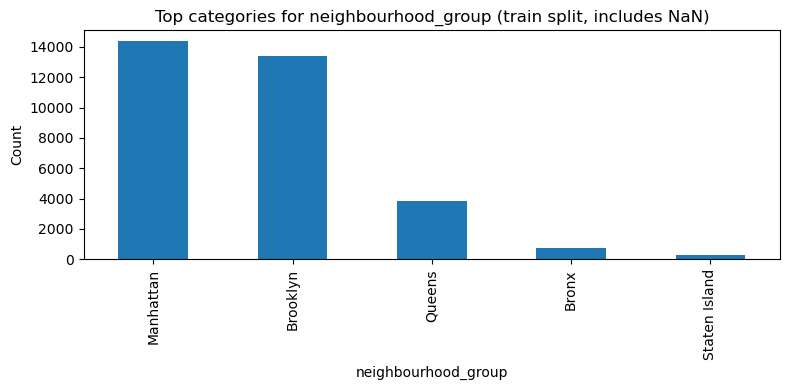

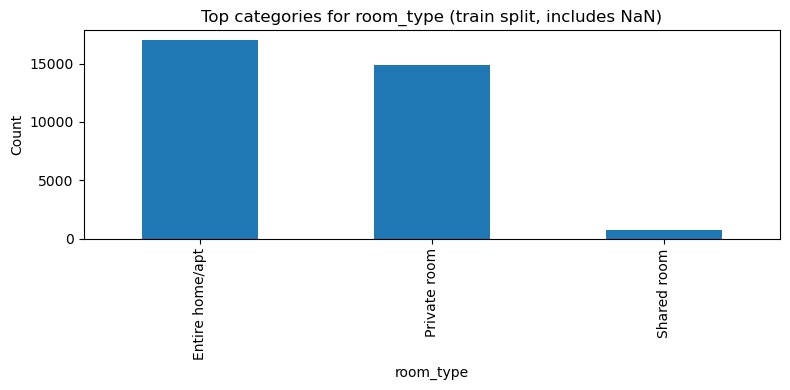

In [26]:
# Plot top categorical distributions for the cleaned train split.
cat_cols = train_split_df.select_dtypes(include=["object", "category"]).columns.tolist()

for col in cat_cols:
    plt.figure(figsize=(8, 4))
    train_split_df[col].value_counts(dropna=False).head(20).plot(kind="bar")
    plt.title(f"Top categories for {col} (train split, includes NaN)")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

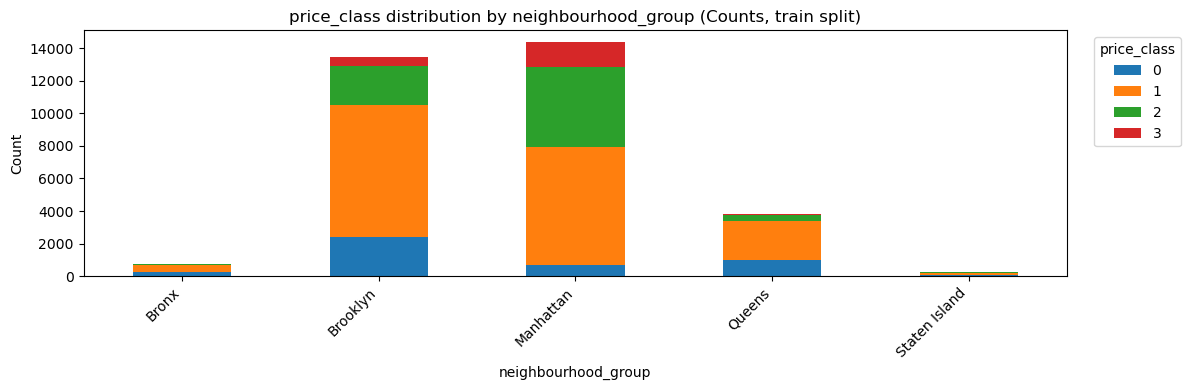

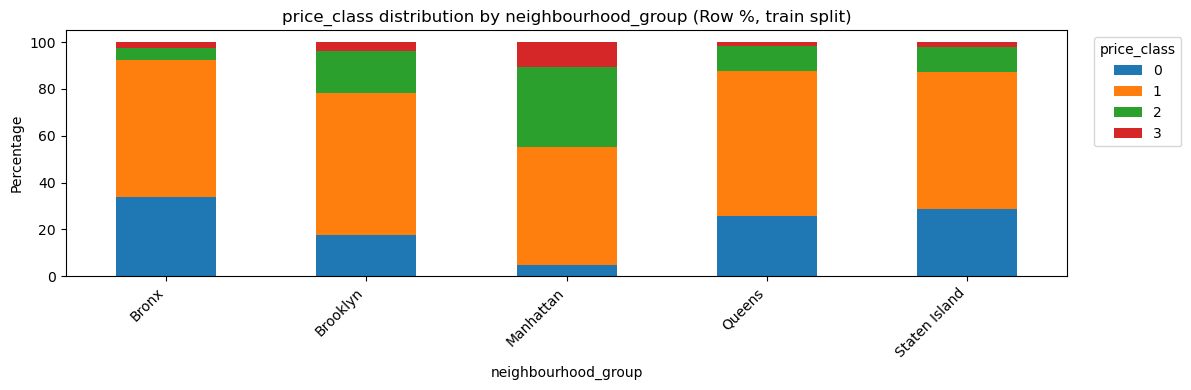

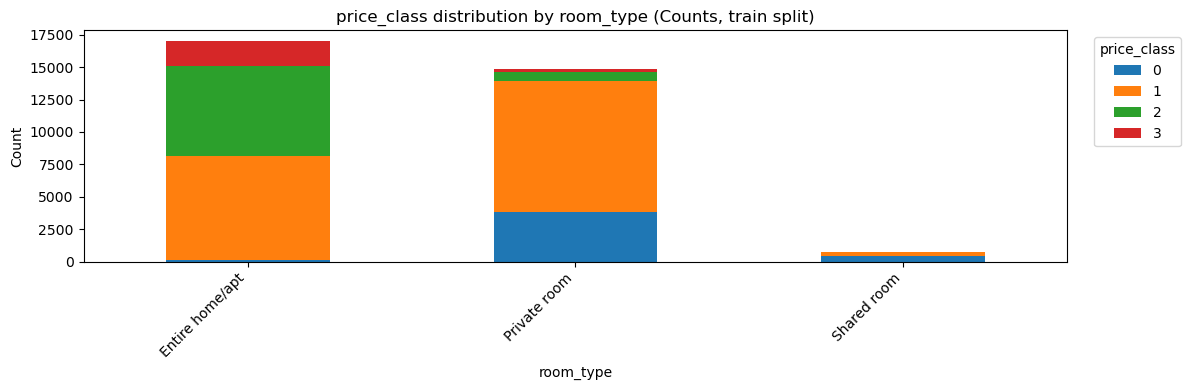

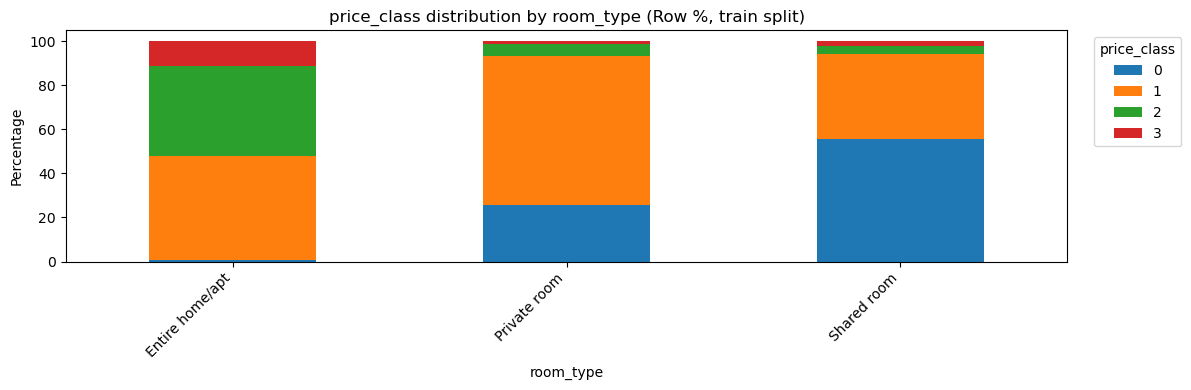

In [27]:
# Visualize target distribution by each categorical feature on the cleaned train split.
target_col = "price_class"

cat_cols = train_split_df.select_dtypes(include=["object", "category"]).columns.drop(target_col, errors="ignore")
top_n = 15

if target_col not in train_split_df.columns:
    print(f"Target column '{target_col}' not found in train_split_df.")
elif len(cat_cols) == 0:
    print("No categorical columns found (object/category) in train split.")
else:
    for col in cat_cols:
        ct = pd.crosstab(train_split_df[col], train_split_df[target_col], dropna=False)

        if ct.shape[0] > top_n:
            totals = ct.sum(axis=1).sort_values(ascending=False)
            keep = totals.head(top_n - 1).index
            other = ct.loc[~ct.index.isin(keep)].sum(axis=0).to_frame().T
            other.index = ["Other"]
            ct = pd.concat([ct.loc[keep], other])


        ax = ct.plot(kind="bar", stacked=True, figsize=(12, 4))
        ax.set_title(f"{target_col} distribution by {col} (Counts, train split)")
        ax.set_xlabel(col)
        ax.set_ylabel("Count")
        plt.xticks(rotation=45, ha="right")
        plt.legend(title=target_col, bbox_to_anchor=(1.02, 1), loc="upper left")
        plt.tight_layout()
        plt.show()

        pct = (ct.div(ct.sum(axis=1), axis=0) * 100).round(2)
        ax = pct.plot(kind="bar", stacked=True, figsize=(12, 4))
        ax.set_title(f"{target_col} distribution by {col} (Row %, train split)")
        ax.set_xlabel(col)
        ax.set_ylabel("Percentage")
        plt.xticks(rotation=45, ha="right")
        plt.legend(title=target_col, bbox_to_anchor=(1.02, 1), loc="upper left")
        plt.tight_layout()
        plt.show()

Numeric columns: ['minimum_nights', 'amenity_score', 'number_of_reviews', 'availability_365']


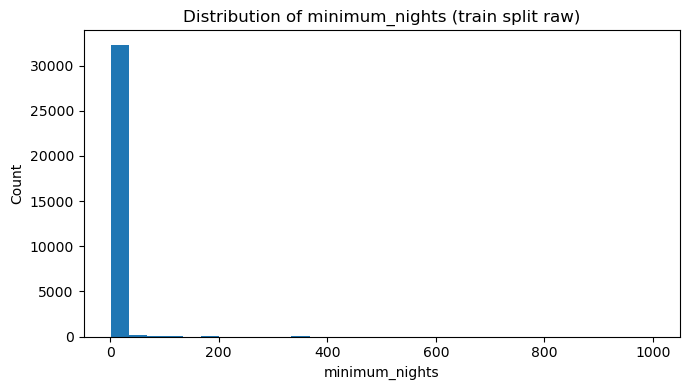

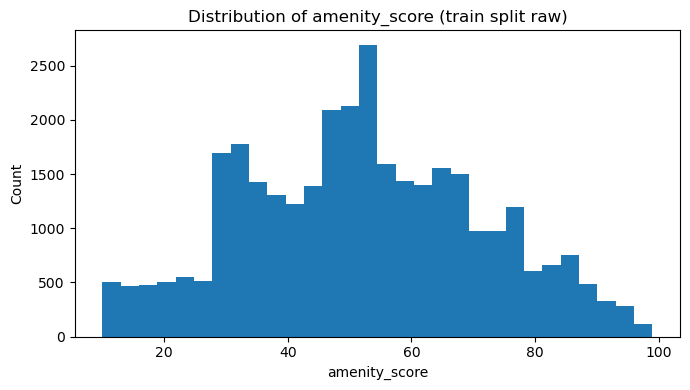

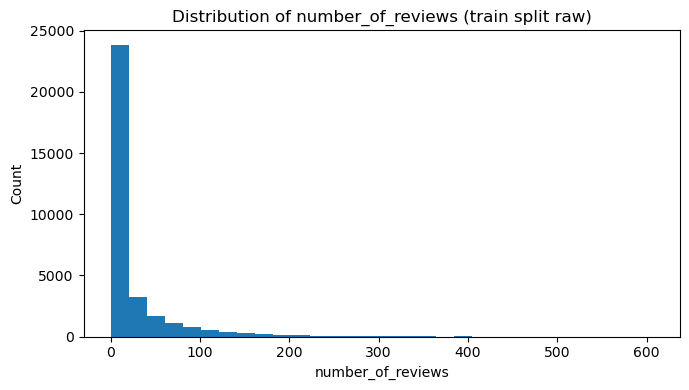

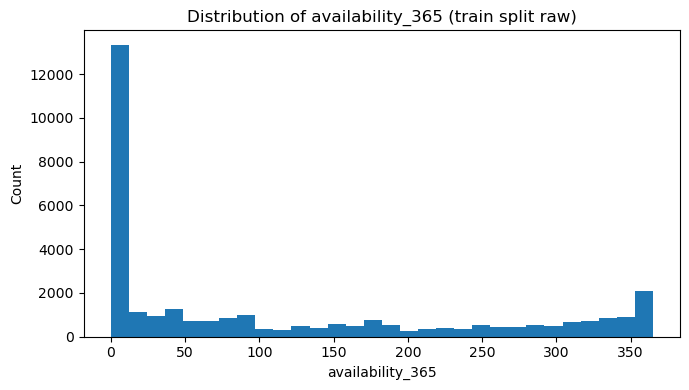

In [28]:
# Plot numeric feature histograms for the cleaned train split.
df_num = train_split_df.copy()
target = target_col if "target_col" in globals() else "price_class"

num_cols = (
    num_cols_rel
    if "num_cols_rel" in globals()
    else df_num.select_dtypes(exclude=["object"]).columns.tolist()
)

if target in num_cols:
    num_cols.remove(target)

print("Numeric columns:", num_cols)

if len(num_cols) == 0:
    print("No numeric columns found.")
else:
    for col in num_cols:
        plt.figure(figsize=(7, 4))
        plt.hist(df_num[col], bins=30)
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.title(f"Distribution of {col} (train split raw)")
        plt.tight_layout()
        plt.show()

In [29]:
# Recompute numeric feature relationship strength with the target on the cleaned train split.
target_col = "price_class"
df_rel = train_split_df.copy()

if target_col not in df_rel.columns:
    raise ValueError(f"'{target_col}' not found in train_split_df.")

num_cols_rel = df_rel.select_dtypes(exclude=["object"]).columns.tolist()
if target_col in num_cols_rel:
    num_cols_rel.remove(target_col)

target_is_numeric = pd.api.types.is_numeric_dtype(df_rel[target_col])
y_rel = df_rel[target_col] if target_is_numeric else df_rel[target_col].astype("category").cat.codes

if len(num_cols_rel) > 0:
    num_strength = df_rel[num_cols_rel].corrwith(y_rel)
    num_strength = num_strength.sort_values(key=lambda s: s.abs(), ascending=False, na_position="last")

    print("Top numeric features by relationship strength with target (train split):")
    display(num_strength.to_frame("corr_with_target").head(15))
else:
    num_strength = pd.Series(dtype=float)
    print("No numeric feature found in train split.")

Top numeric features by relationship strength with target (train split):


,corr_with_target
amenity_score,0.867105
availability_365,0.093700
number_of_reviews,-0.029940
minimum_nights,0.016613


<Figure size 700x400 with 0 Axes>

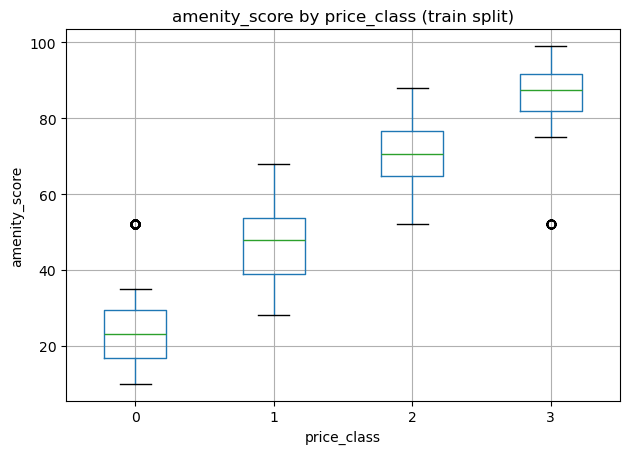

<Figure size 700x400 with 0 Axes>

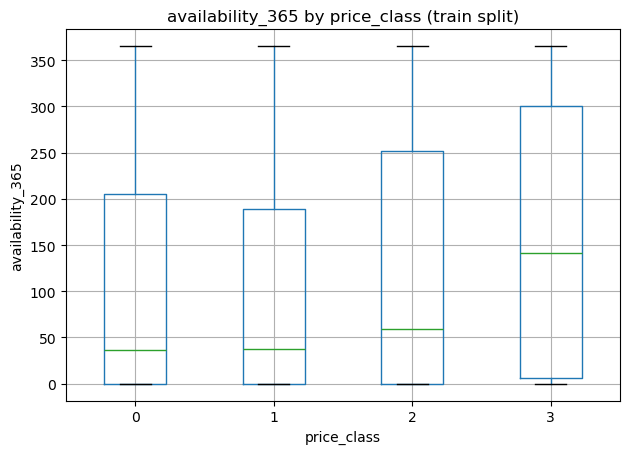

<Figure size 700x400 with 0 Axes>

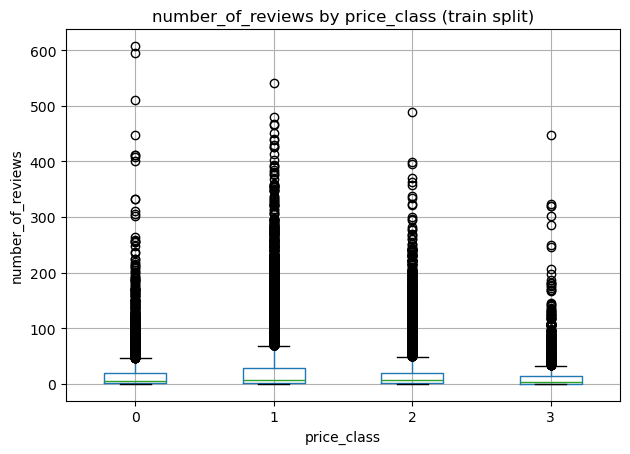

<Figure size 700x400 with 0 Axes>

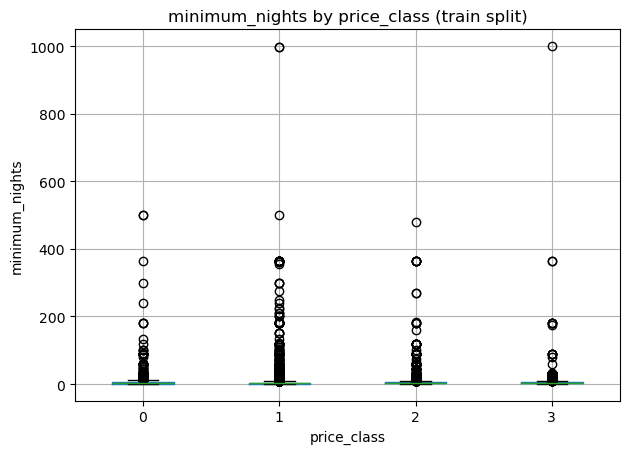

In [30]:
# Visualize top numeric features against the target with boxplots on the train split.
top_num = num_strength.head(6).index.tolist()

for col in top_num:
    if target_is_numeric:
        plt.figure(figsize=(7, 4))
        train_split_df.boxplot(column=col, by=target_col)
        plt.title(f"{col} by {target_col} (train split)")
        plt.suptitle("")
        plt.xlabel(target_col)
        plt.ylabel(col)
        plt.tight_layout()
        plt.show()

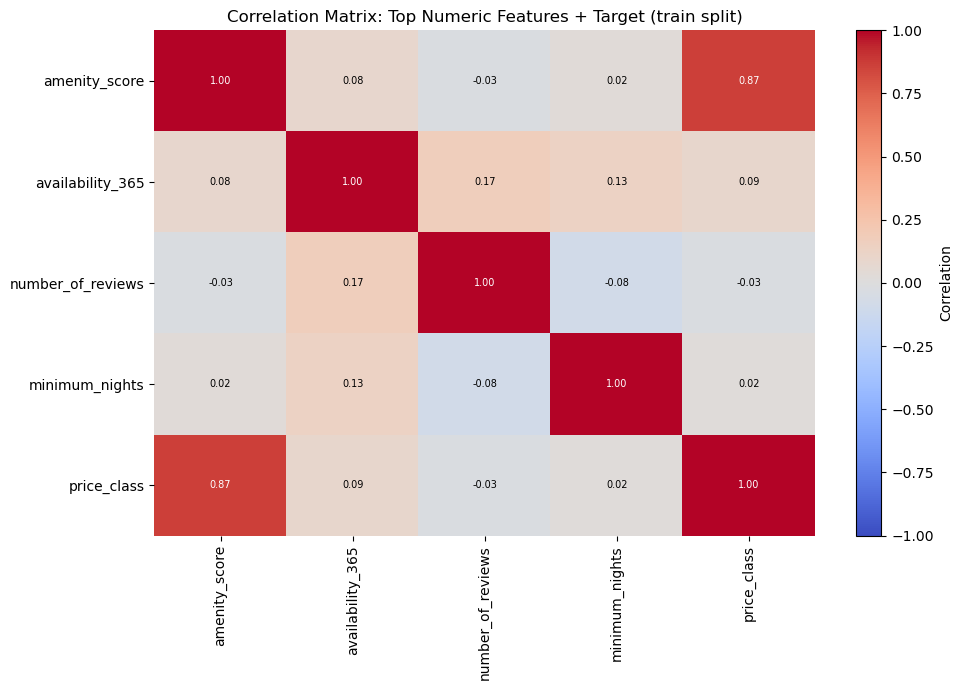

In [31]:
# Build a correlation heatmap for top numeric features and target on the train split.
top_corr_cols = num_strength.head(10).index.tolist()

if len(top_corr_cols) >= 2:
    corr_df = train_split_df[top_corr_cols].copy()

    if target_is_numeric:
        corr_df[target_col] = train_split_df[target_col]
    else:
        corr_df[f"{target_col}_code"] = y_rel

    corr_mat = corr_df.corr()

    fig, ax = plt.subplots(figsize=(10, 7))
    img = ax.imshow(
        corr_mat.values,
        cmap="coolwarm",
        vmin=-1,
        vmax=1,
        aspect="auto",
        interpolation="nearest"
    )

    ax.grid(False)
    ax.set_xticks(range(len(corr_mat.columns)))
    ax.set_yticks(range(len(corr_mat.index)))
    ax.set_xticklabels(corr_mat.columns, rotation=90)
    ax.set_yticklabels(corr_mat.index)

    for spine in ax.spines.values():
        spine.set_visible(False)

    for i in range(corr_mat.shape[0]):
        for j in range(corr_mat.shape[1]):
            v = corr_mat.iloc[i, j]
            c = "white" if abs(v) >= 0.5 else "black"
            ax.text(j, i, f"{v:.2f}", ha="center", va="center", color=c, fontsize=7)

    fig.colorbar(img, ax=ax, label="Correlation")
    ax.set_title("Correlation Matrix: Top Numeric Features + Target (train split)")
    fig.tight_layout()
    plt.show()
else:
    print("Not enough numeric features for this heatmap.")

In [32]:
# Fit preprocessing on train split, transform train and validation, and save processed datasets.
target_col = "price_class"

train_source = train_split_df.copy()
val_source = val_split_df.copy()

if target_col not in train_source.columns or target_col not in val_source.columns:
    raise ValueError(f"'{target_col}' must exist in both train_split_df and val_split_df.")

X_train_df = train_source.drop(columns=[target_col]).copy()
y_train = train_source[target_col].copy()

X_val_df = val_source.drop(columns=[target_col]).copy()
y_val = val_source[target_col].copy()

categorical_cols = [c for c in ["neighbourhood_group", "room_type"] if c in X_train_df.columns]
skewed_cols = [c for c in ["minimum_nights", "number_of_reviews"] if c in X_train_df.columns]
numeric_cols = X_train_df.select_dtypes(include=["number"]).columns.tolist()
other_num_cols = [c for c in numeric_cols if c not in skewed_cols]

try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

num_skewed_pipe = Pipeline([
    ("log1p", FunctionTransformer(np.log1p, feature_names_out="one-to-one")),
    ("scaler", StandardScaler()),
])

num_other_pipe = Pipeline([
    ("scaler", StandardScaler()),
])

preprocessor_train = ColumnTransformer(
    transformers=[
        ("num_skewed", num_skewed_pipe, skewed_cols),
        ("num_other", num_other_pipe, other_num_cols),
        ("cat", ohe, categorical_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)

X_train_processed = preprocessor_train.fit_transform(X_train_df)
X_val_processed = preprocessor_train.transform(X_val_df)

feature_names = [n.split("__", 1)[-1] for n in preprocessor_train.get_feature_names_out()]

train_processed_df = pd.DataFrame(X_train_processed, columns=feature_names, index=X_train_df.index)
train_processed_df[target_col] = y_train.values

val_processed_df = pd.DataFrame(X_val_processed, columns=feature_names, index=X_val_df.index)
val_processed_df[target_col] = y_val.values

print("train_processed_df shape:", train_processed_df.shape)
print("val_processed_df shape  :", val_processed_df.shape)

display(train_processed_df.head())
display(val_processed_df.head())

train_processed_df.to_csv("train_processed_with_target.csv", index=False)
val_processed_df.to_csv("val_processed_with_target.csv", index=False)
print("Saved: train_processed_with_target.csv")
print("Saved: val_processed_with_target.csv")

train_processed_df shape: (32637, 13)
val_processed_df shape  : (8270, 13)


,minimum_nights,number_of_reviews,amenity_score,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,price_class
35004,0.331798,-0.423370,1.925787e+00,-0.766399,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,3
35818,1.788883,-1.328274,3.684923e-16,-0.552314,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1
6658,-0.945994,-0.875822,-2.056868e-01,-0.223540,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1
31372,-0.945994,-0.875822,3.751529e-01,-0.858150,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2
25775,-0.945994,0.105965,-2.134904e+00,-0.452917,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0


,minimum_nights,number_of_reviews,amenity_score,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,price_class
38358,-0.474399,1.664564,0.240315,-0.644065,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2
31497,2.164299,1.690678,-0.190129,0.418716,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1
20761,1.543110,-1.328274,-2.067486,-0.498793,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0
25947,1.894692,-0.875822,-1.009527,-0.766399,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0
38943,-0.945994,0.105965,1.785764,1.405037,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2


Saved: train_processed_with_target.csv
Saved: val_processed_with_target.csv


In [33]:
# Save the fitted training preprocessor for reuse in later steps.
joblib.dump(preprocessor_train, "preprocessor_train.joblib")
print("Saved: preprocessor_train.joblib")

Saved: preprocessor_train.joblib
